In [1]:
import os
import torch
from model import replace_fc_layer, load_checkpoint
from mcunet.mcunet.model_zoo import build_model
import torch.nn as nn

In [10]:
model, optimizer = load_checkpoint("checkpoints/device_0_checkpoint.pth")
weight = model.classifier.weight.data

In [2]:
model2, resolution, description = build_model(net_id="mcunet-in3", pretrained=True)
model2 = replace_fc_layer(model2, 10)

In [2]:
model = load_checkpoint("./checkpoints/baseline_checkpoint_80.pth")


In [5]:
model2.first_conv.conv = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [12]:
model2.classifier.weight.data = weight

In [13]:
model2.classifier.weight.data

tensor([[ 0.0512,  0.0375,  0.0081,  ..., -0.0418,  0.0016,  0.0161],
        [-0.0346, -0.0411, -0.0662,  ..., -0.0101,  0.0288,  0.0596],
        [ 0.0088,  0.0588, -0.0079,  ..., -0.0399,  0.0230,  0.0175],
        ...,
        [-0.0052, -0.0124, -0.0114,  ...,  0.0397, -0.0349,  0.0437],
        [-0.0549,  0.0351,  0.0417,  ..., -0.0242, -0.0100, -0.0258],
        [ 0.0423,  0.0002, -0.0330,  ...,  0.0102, -0.0125,  0.0076]])

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from typing import List, Tuple
import torchvision
import torchvision.transforms as transforms

def _download_data(dataset_name: str):
    transform = transforms.Compose([transforms.ToTensor()])
    
    if dataset_name == "cifar10":
        trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=False, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./dataset', train=False, download=False, transform=transform)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    
    return trainset, testset

def partition_data_dirichlet(
    num_clients, alpha, batch_size, seed=42, dataset_name="cifar10"
) -> Tuple[List[DataLoader], DataLoader]:
    """Partition according to the Dirichlet distribution.

    Parameters
    ----------
    num_clients : int
        The number of clients that hold a part of the data
    alpha: float
        Parameter of the Dirichlet distribution
    batch_size: int
        Batch size for the data loaders
    seed : int, optional
        Used to set a fix seed to replicate experiments, by default 42
    dataset_name : str
        Name of the dataset to be used

    Returns
    -------
    Tuple[List[DataLoader], DataLoader]
        The list of data loaders for each client, the test data loader.
    """
    trainset, testset = _download_data(dataset_name)
    min_required_samples_per_client = 10
    min_samples = 0
    prng = np.random.default_rng(seed)

    # get the targets
    tmp_t = trainset.targets
    if isinstance(tmp_t, list):
        tmp_t = np.array(tmp_t)
    if isinstance(tmp_t, torch.Tensor):
        tmp_t = tmp_t.numpy()
    num_classes = len(set(tmp_t))
    total_samples = len(tmp_t)
    while min_samples < min_required_samples_per_client:
        idx_clients: List[List[int]] = [[] for _ in range(num_clients)]
        for k in range(num_classes):
            idx_k = np.where(tmp_t == k)[0]
            prng.shuffle(idx_k)
            proportions = prng.dirichlet(np.repeat(alpha, num_clients))
            proportions = np.array(
                [
                    p * (len(idx_j) < total_samples / num_clients)
                    for p, idx_j in zip(proportions, idx_clients)
                ]
            )
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            idx_k_split = np.split(idx_k, proportions)
            idx_clients = [
                idx_j + idx.tolist() for idx_j, idx in zip(idx_clients, idx_k_split)
            ]
            min_samples = min([len(idx_j) for idx_j in idx_clients])

    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]

    # Create data loaders for each client
    client_dataloaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in trainsets_per_client]
    test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return client_dataloaders, test_dataloader

# Example usage
num_clients = 20
alpha = 20
batch_size = 128

client_dataloaders, test_dataloader = partition_data_dirichlet(num_clients, alpha, batch_size)

# Print the number of samples for each client
for client_id, dataloader in enumerate(client_dataloaders):
    print(f"Client {client_id}: {len(dataloader.dataset)} samples")

Client 0: 2649 samples
Client 1: 2759 samples
Client 2: 2449 samples
Client 3: 2452 samples
Client 4: 2454 samples
Client 5: 2299 samples
Client 6: 2716 samples
Client 7: 2457 samples
Client 8: 2491 samples
Client 9: 2577 samples
Client 10: 2308 samples
Client 11: 2469 samples
Client 12: 2450 samples
Client 13: 2676 samples
Client 14: 2346 samples
Client 15: 2496 samples
Client 16: 2427 samples
Client 17: 2560 samples
Client 18: 2477 samples
Client 19: 2488 samples


In [1]:
import numpy as np
import importlib
import dataset
importlib.reload(dataset)
from dataset import get_nonIID_dataloader, split_dataset_by_dirichlet
dataloaders = split_dataset_by_dirichlet("./dataset")


c:\Users\Lance Bao\anaconda3\envs\HITL\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


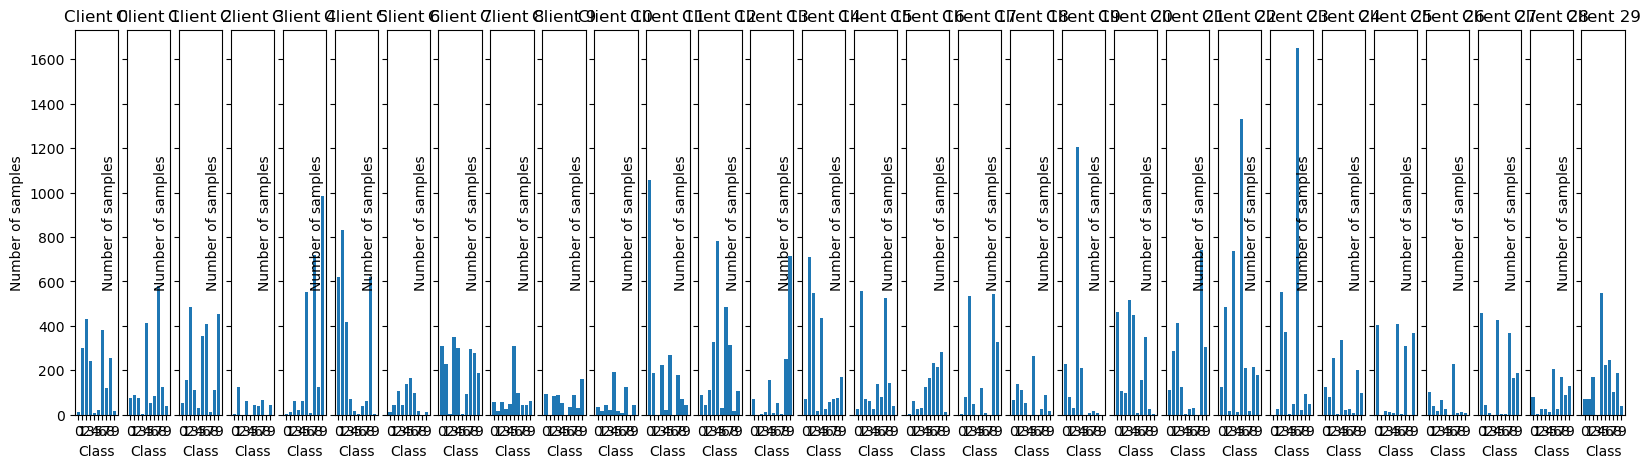

In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict

"""Plot the class distribution for each client."""
# client_dataloaders = dataloaders[0]
num_clients = len(dataloaders)
class_counts = defaultdict(lambda: np.zeros(10))

for client_id, dataloader in enumerate(dataloaders):
    for _, targets in dataloader:
        for target in targets:
            class_counts[client_id][target.item()] += 1

fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), sharey=True)
if num_clients == 1:
    axes = [axes]

for client_id, ax in enumerate(axes):
    ax.bar(range(10), class_counts[client_id])
    ax.set_title(f'Client {client_id}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of samples')
    ax.set_xticks(range(10))

plt.show()

In [27]:
list = [1,4,2,4,6,7,3,61,6,8,29]
counter = 0
running_average = 0
for i in range(len(list)):
    counter += 1
    running_average = running_average + (list[i] - running_average) / counter
    print(running_average)
    print(np.mean(list[:i-len(list)+1]))
    print("__________________")




1.0
1.0
__________________
2.5
2.5
__________________
2.3333333333333335
2.3333333333333335
__________________
2.75
2.75
__________________
3.4
3.4
__________________
4.0
4.0
__________________
3.857142857142857
3.857142857142857
__________________
11.0
11.0
__________________
10.444444444444445
10.444444444444445
__________________
10.2
10.2
__________________
11.909090909090908
nan
__________________


c:\Users\Lance Bao\anaconda3\envs\HITL\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Lance Bao\anaconda3\envs\HITL\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
import matplotlib.pyplot as plt

acc = []
f1 = []
with open("result.txt", "r") as f:
    # read every line
    for line in f:
        # split the line into words
        words = line.split(', ')
        # convert the first word to an integer
        acc.append(float(words[1]))
        f1.append(float(words[2]))
        

{'whiskers': [<matplotlib.lines.Line2D at 0x1b424914e80>,
 'caps': [<matplotlib.lines.Line2D at 0x1b424926460>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b424914b80>,
 'medians': [<matplotlib.lines.Line2D at 0x1b424926a00>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b424926cd0>,
 'means': []}

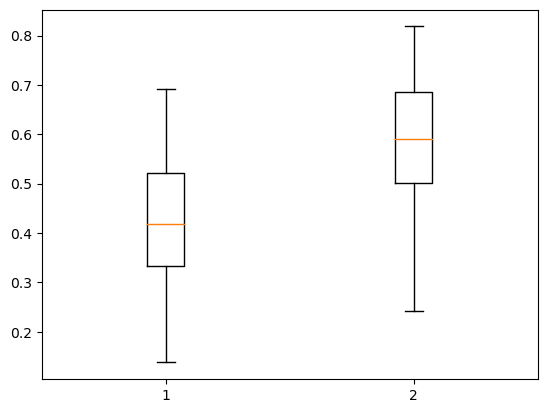

In [46]:
fig, ax = plt.subplots()
acc.sort()
f1.sort()
ax.boxplot([acc, f1])


(array([1., 3., 2., 4., 6., 9., 7., 9., 6., 3.]),
 array([0.2421 , 0.29972, 0.35734, 0.41496, 0.47258, 0.5302 , 0.58782,
        0.64544, 0.70306, 0.76068, 0.8183 ]),
 <BarContainer object of 10 artists>)

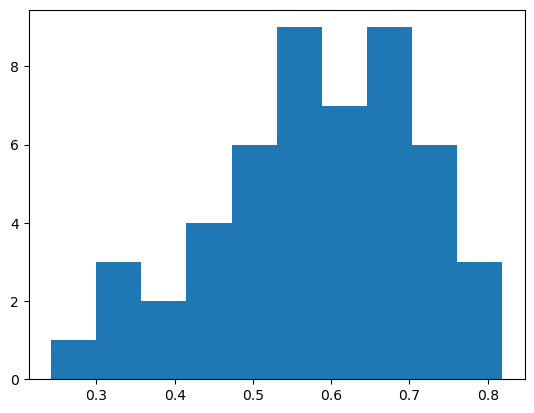

In [44]:
fig, ax = plt.subplots()
ax.hist(f1, bins=10)

In [4]:
import numpy as np
import os
from model import load_checkpoint, set_parameters, get_parameters
from eval import evaluate_model
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from configuration import DATA_PATH, BATCH_SIZE, DEVICE
from flwr.common import NDArrays, parameters_to_ndarrays, ndarrays_to_parameters
from functools import reduce
from flwr.common.typing import (
    NDArrays,
)

2024-08-15 00:23:55,603	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [110]:
models_folder = './checkpoints'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_dataset = CIFAR10(root=DATA_PATH, train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model_files = [f for f in os.listdir(models_folder) if f.endswith('.pth') and 'device' in f]

def cumulative_fedAvg(total_weight, weight, total_samples, num_samples):
    result_weights = []
    for w1, w2 in zip(total_weight, weight):
        combined_weight = w1 + w2 * num_samples
        result_weights.append(combined_weight)
    total_samples += num_samples
    return result_weights, total_samples

def aggregate_model(model, total_weights, total_samples):
    avg_weights = [weight / total_samples for weight in total_weights]
    set_parameters(model, avg_weights)
    return model

total_samples = 0
total_weights = None  # Start as None to check the first iteration

for model_file in model_files:
    model, num_sample = load_checkpoint(os.path.join(models_folder, model_file))
    weight = get_parameters(model)

    if total_weights is None:
        # Initialize total_weights in the first iteration
        total_weights = [param * num_sample for param in weight]
    else:
        total_weights, total_samples = cumulative_fedAvg(total_weights, weight, total_samples, num_sample)

# Final aggregation and evaluation
model, _ = load_checkpoint(os.path.join(models_folder, "baseline_checkpoint_2.pth"))
# accuracy, f1 = evaluate_model(model, test_loader, DEVICE)
# print(f"Accuracy: {accuracy}, F1: {f1}")
model = aggregate_model(model, total_weights, total_samples)
accuracy, f1 = evaluate_model(model, test_loader, DEVICE)
print(f"Accuracy: {accuracy}, F1: {f1}")

Accuracy: 0.6642, F1: 0.7982213676240836


In [6]:
models_folder = './checkpoints'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_dataset = CIFAR10(root=DATA_PATH, train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model_files = [f for f in os.listdir(models_folder) if f.endswith('.pth') and 'device' in f]

def cumulative_fedAvg(total_weight, weight, total_samples, num_samples):
    result_weights = []
    for w1, w2 in zip(total_weight, weight):
        combined_weight = w1 + w2 * num_samples
        result_weights.append(combined_weight)
    total_samples += num_samples
    return result_weights, total_samples

def aggregate_model(model, total_weights, total_samples):
    avg_weights = [weight / total_samples for weight in total_weights]
    set_parameters(model, avg_weights)
    return model

def test(model, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}")
    return accuracy, loss

total_samples = 0
total_weights = None  # Start as None to check the first iteration
results = []
# sort the model files
# model_files = ['device_0_checkpoint.pth','device_1_checkpoint.pth','device_2_checkpoint.pth']
print(model_files)
for model_file in model_files[:25]:
    model, num_sample, opt = load_checkpoint(os.path.join(models_folder, model_file))
    print(f"file: {model_file} num_sample: {num_sample}")
    weight = get_parameters(model)
    print(weight[0][0][:5])
    results.append((weight, num_sample))
print(f"num_results: {len(results)}")
num_examples_total = sum(num_examples for (_, num_examples) in results)
print(f"num_examples_total: {num_examples_total}")
weighted_weights = [
        [layer * num_examples for layer in weights] for weights, num_examples in results
    ]

weights_prime: NDArrays = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_weights)
    ]



model, _, _ = load_checkpoint(os.path.join(models_folder, "device_0_checkpoint.pth"))
model.to(DEVICE)

# Final aggregation and evaluation
set_parameters(model, weights_prime)
print(model.classifier[0].weight.data)

accuracy, _ = evaluate_model(model, test_loader, DEVICE)
print(f"Accuracy: {accuracy}")

['device_0_checkpoint.pth', 'device_10_checkpoint.pth', 'device_11_checkpoint.pth', 'device_12_checkpoint.pth', 'device_13_checkpoint.pth', 'device_14_checkpoint.pth', 'device_15_checkpoint.pth', 'device_16_checkpoint.pth', 'device_17_checkpoint.pth', 'device_18_checkpoint.pth', 'device_19_checkpoint.pth', 'device_1_checkpoint.pth', 'device_20_checkpoint.pth', 'device_21_checkpoint.pth', 'device_22_checkpoint.pth', 'device_23_checkpoint.pth', 'device_24_checkpoint.pth', 'device_25_checkpoint.pth', 'device_26_checkpoint.pth', 'device_27_checkpoint.pth', 'device_28_checkpoint.pth', 'device_29_checkpoint.pth', 'device_2_checkpoint.pth', 'device_3_checkpoint.pth', 'device_4_checkpoint.pth', 'device_5_checkpoint.pth', 'device_6_checkpoint.pth', 'device_7_checkpoint.pth', 'device_8_checkpoint.pth', 'device_9_checkpoint.pth']
file: device_0_checkpoint.pth num_sample: 1030.2352689900806
[-0.01568552  0.00806634 -0.02992665 -0.00263323 -0.02734814]
file: device_10_checkpoint.pth num_sample: 992

In [10]:
import torch
import torch.nn as nn
classifier_1  = nn.Sequential(
		nn.Linear(128, 128),
		nn.ReLU(),
		#nn.Dropout(0.2),  
		nn.Linear(128, 64),
		nn.ReLU(),
		#nn.Dropout(0.2),  
		nn.Linear(64, 10)
	)

classifier_2  = nn.Sequential(
		nn.Linear(128, 128),
		nn.ReLU(),
		#nn.Dropout(0.2),  
		nn.Linear(128, 64),
		nn.ReLU(),
		#nn.Dropout(0.2),  
		nn.Linear(64, 10)
	)

print(classifier_1[0].weight.data)
print(classifier_2[0].weight.data)


results = []
weight_1 = [val.cpu().numpy() for _, val in classifier_1.state_dict().items()]
weight_2 = [val.cpu().numpy() for _, val in classifier_2.state_dict().items()]
results.append((weight_1, 10))
results.append((weight_2, 20))
num_examples_total = sum(num_examples for (_, num_examples) in results)
print(f"num_examples_total: {num_examples_total}")
weighted_weights = [
        [layer * num_examples for layer in weights] for weights, num_examples in results
    ]

weights_prime: NDArrays = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_weights)
    ]
print(weights_prime[0])

tensor([[-6.2708e-03, -5.5009e-02,  2.1453e-02,  ..., -2.7314e-05,
         -5.0167e-02, -1.5584e-02],
        [ 6.3049e-02, -5.8313e-02, -7.4511e-03,  ...,  3.3516e-02,
          1.0020e-02, -4.5818e-02],
        [-1.3214e-02, -3.8769e-02, -8.7629e-02,  ..., -2.5150e-02,
          2.6412e-02, -6.7961e-02],
        ...,
        [-3.7797e-02, -2.3361e-02, -4.2847e-02,  ...,  4.7979e-02,
          7.9452e-02,  3.3328e-02],
        [-6.5162e-02, -4.7225e-02,  5.3119e-02,  ...,  8.6284e-02,
         -2.9658e-02, -2.1219e-02],
        [-6.4294e-02,  8.0660e-02,  2.5899e-02,  ..., -5.0136e-02,
         -9.3591e-03,  5.7799e-02]])
tensor([[ 0.0884, -0.0753,  0.0346,  ..., -0.0196, -0.0551,  0.0796],
        [ 0.0836,  0.0422, -0.0608,  ...,  0.0466,  0.0317, -0.0854],
        [ 0.0389, -0.0353,  0.0321,  ...,  0.0004, -0.0363, -0.0283],
        ...,
        [ 0.0162, -0.0391,  0.0764,  ..., -0.0377,  0.0279, -0.0477],
        [-0.0561, -0.0731,  0.0275,  ..., -0.0598,  0.0657, -0.0348],
     

In [17]:
print(weights_prime[0] - (weight_1[0]*10 + weight_2[0]*20)/30)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [83]:
(0.0434*1667+0.0433*964+0.0301*1798)/(1667+964+1798)

0.037978956875141114